## Проект: вариант 3

Представьте, что вы работаете в крупном дейтинговом приложении. 

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

### Проверьте:

Был ли эксперимент успешен в целом.
Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.

*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.

In [1]:
#импортируем нужные библиотеки 
import pandas as pd
from datetime import datetime
from datetime import timedelta
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import norm
import numpy as np
from tqdm.auto import tqdm
import statsmodels.api as sm
from scipy.stats import chi2_contingency

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
#загружаем нужные файлы
users_test        = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-sarksjan/my_project/Проект_3_users_test.csv', sep = ";") 
users_control_1   = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-sarksjan/my_project/Проект_3_users_control_1.csv', sep = ";")  
users_control_2   = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-sarksjan/my_project/Проект_3_users_control_2.csv', sep = ";") 
 

In [3]:
#при анализе данных обнаружено, что необходимо перевести колонки с датами к формату datetime, добавляем сразу при загрузке
transactions_test = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-sarksjan/my_project/Проект_3_transactions_test.csv', sep = ";", 
                                parse_dates = ['joined_at', 'paid_at'])
trans_control_1   = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-sarksjan/my_project/Проект_3_transactions_control_1.csv', sep = ";", 
                                parse_dates = ['joined_at', 'paid_at'])  
trans_control_2   = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-sarksjan/my_project/Проект_3_transactions_control_2.csv', sep = ";",
                                parse_dates = ['joined_at', 'paid_at'])

In [4]:
#создаем функцию для вывода некоторых общих показателей
def analysis_first(x):
    df_info = pd.concat([x.dtypes, x.nunique(), x.isna().sum()], axis=1).reset_index()
    df_info = df_info.rename(columns={'index': 'column', 0: 'Тип данных', 1: 'Уникальные значения', 2: 'Пропуски'})
    print('Количество строк в файле:', x.shape[0])
    print('Количество колонок в файле:', x.shape[1])
    print('Количество дубликатов:', x.duplicated().sum())
    return df_info

## Первичный анализ и предобработка данных

 ### 1. Таблицы users


In [5]:
#посмотрим на общий размер таблиц useres
print(f'Общее число строк и колонок в датасетах группы users:  тест:',users_test.shape, ', контроль 1:',
      users_control_1.shape, ', контроль 2:', users_control_2.shape)

Общее число строк и колонок в датасетах группы users:  тест: (4308, 13) , контроль 1: (4340, 13) , контроль 2: (4264, 13)


Таблица users_test

In [6]:
#применяем функцию
analysis_first(users_test)

Количество строк в файле: 4308
Количество колонок в файле: 13
Количество дубликатов: 0


,column,Тип данных,Уникальные значения,Пропуски
0,uid,int64,4308,0
1,age,int64,57,0
2,attraction_coeff,int64,600,0
3,coins,float64,28,4259
4,country,object,51,0
5,visit_days,object,891,1330
6,gender,int64,2,0
7,age_filter_start,int64,51,0
8,age_filter_end,int64,78,0
9,views_count,int64,331,0


Таблица users_control_1

In [7]:
#применяем функцию
analysis_first(users_control_1)

Количество строк в файле: 4340
Количество колонок в файле: 13
Количество дубликатов: 0


,column,Тип данных,Уникальные значения,Пропуски
0,uid,int64,4340,0
1,age,int64,56,0
2,attraction_coeff,int64,587,0
3,coins,float64,22,4280
4,country,object,40,0
5,visit_days,object,880,1324
6,gender,int64,2,0
7,age_filter_start,int64,53,0
8,age_filter_end,int64,78,0
9,views_count,int64,339,0


Таблица users_control_2

In [8]:
#применяем функцию
analysis_first(users_control_2)

Количество строк в файле: 4264
Количество колонок в файле: 13
Количество дубликатов: 0


,column,Тип данных,Уникальные значения,Пропуски
0,uid,int64,4264,0
1,age,int64,59,0
2,attraction_coeff,int64,585,0
3,coins,float64,23,4203
4,country,object,45,0
5,visit_days,object,837,1364
6,gender,int64,2,0
7,age_filter_start,int64,56,0
8,age_filter_end,int64,79,0
9,views_count,int64,328,0


In [9]:
#общая описательная статистика тестовой и контрольных таблиц
users_test[['age', 'total_revenue', 'views_count']]\
.describe()\
.rename(columns={'age': 'age_test',
                 'total_revenue': 'total_revenue_test'})\
.join(users_control_1[['age', 'total_revenue']]\
            .describe()\
            .rename(columns={'age': 'age_control_1',
                             'total_revenue': 'total_revenue_control_1'}))\
.join(users_control_2[['age', 'total_revenue']]\
            .describe()\
            .rename(columns={'age': 'age_control_2',
                             'total_revenue': 'total_revenue_control_2'}))\
[['age_test', 'age_control_1', 'age_control_2', 
  'total_revenue_test', 'total_revenue_control_1', 'total_revenue_control_2']]

,age_test,age_control_1,age_control_2,total_revenue_test,total_revenue_control_1,total_revenue_control_2
count,4308.000000,4340.000000,4264.000000,4308.000000,4340.000000,4264.000000
mean,31.889276,32.095392,32.046201,534.080316,594.761982,450.384146
std,10.245287,10.257466,10.170721,4371.682632,7987.922925,2859.242228
min,16.000000,16.000000,16.000000,0.000000,0.000000,0.000000
25%,25.000000,24.000000,25.000000,0.000000,0.000000,0.000000
50%,30.000000,30.000000,30.000000,0.000000,0.000000,0.000000
75%,38.000000,38.000000,38.000000,0.000000,0.000000,0.000000
max,99.000000,99.000000,99.000000,129870.000000,486330.000000,81796.000000


Итак, при первом анализе данных группы users мы видим, что колонки таблицы совпадают, количество строк сильно не различается, дубликаты отсутствуют, имеются пропуски в колонках coins,visit_days, was_premium, is_premium.

* Кроме того, мы видим, что возрастной диапазон пользователей растянут от 16 до 99 лет (немного странно, что верхняя граница возраста так высока, скорее всего вводились неверные данные), при этом 50% пользователей младше 30 лет и всего 25% старше 38 лет. 
* Уникальное количество стран в группах различается(тест - 51, контроль 1 - 40, контроль 2 - 45)
* Распределение total_revenue отличается от нормального, максимальные значения сильно разнятся в группах

### Объединение и дальнейшая обработка таблицы с пользователями

Объединим датасеты из группы users в один датасет. При этом добавим колонку, в которой будет содержаться указание из какой группы были внесены данные (тест, контроль 1 и контроль 2).

In [10]:
users_test['group'] = 'test'
users_control_1['group'] = 'control_1'
users_control_2['group'] = 'control_2'
all_users = pd.concat([users_test, users_control_1, users_control_2], ignore_index=True)

In [11]:
#применяем функцию
analysis_first(all_users)

Количество строк в файле: 12912
Количество колонок в файле: 14
Количество дубликатов: 0


,column,Тип данных,Уникальные значения,Пропуски
0,uid,int64,12912,0
1,age,int64,69,0
2,attraction_coeff,int64,847,0
3,coins,float64,50,12742
4,country,object,72,0
5,visit_days,object,2132,4018
6,gender,int64,2,0
7,age_filter_start,int64,67,0
8,age_filter_end,int64,81,0
9,views_count,int64,564,0


Поскольку колонка coins, отвечает за число монеток (внутренняя валюта) пользователя, то пропуски можем заменить 0, что будет обозначать, что у пользователя нет монеток. 
Тоже самое сделаем и с остальными колонками.

In [12]:
all_users['coins'] = all_users['coins'].fillna(0)
all_users['visit_days'] = all_users['visit_days'].fillna(0)

In [13]:
all_users['was_premium'] = all_users['was_premium'].fillna(0)
all_users['is_premium'] = all_users['is_premium'].fillna(0)

В колонке visit_days перечислены через запятую дни, в которые пользователь посещал приложение после регистрации, при этом в таком формате неудобно считать сколько дней в общем пользователь заходил в приложение, поэтому создадим колонку, в которой будет рассчитана данная информация.

Для этого необходимо будет перевести тип колонки visit_days из object в str.

In [14]:
#меняем тип данных
all_users = all_users.astype({ 'visit_days': 'str'})
#создаем функцию, которая считает кол-во дней посещения поль-ем сайта после рег-ии, и возвращает 0, если такие дни не зафиксированы
all_users['days_sum'] = all_users['visit_days'].apply(lambda x: len(x.split(',')) if x != '0' else 0)

In [15]:
#также для нашего удобства можем указать, что пол 1 - мужчины, а пол 0 - женщины
all_users['gender'] = all_users['gender'].apply(lambda x: 'male' if x == 1 else 'female')

In [16]:
#смотрим на объединенный датафрейм
all_users.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,days_sum
0,892309896,27,685,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",male,24,30,89,0.0,0.0,0,test,14
1,892044516,27,0,0.0,Germany,0,male,24,30,0,0.0,0.0,0,test,0
2,892185708,45,44,0.0,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",male,42,48,68,0.0,0.0,0,test,20
3,892130292,32,0,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",male,29,35,0,0.0,0.0,0,test,12
4,891406035,27,1000,0.0,France,0,male,24,30,1,1.0,0.0,0,test,0


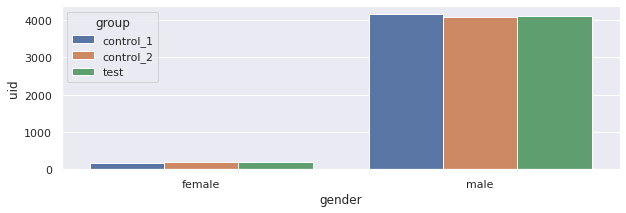

In [17]:
#смотрим на распределение пользователей по группам и полу
sns.set(rc={'figure.figsize': (10, 3)})
gender_users = all_users.groupby(['group','gender'], as_index = False) \
                         .agg({'uid':'count'})
sns.barplot(data=gender_users, x= "gender", y= 'uid', hue = 'group')
plt.show()

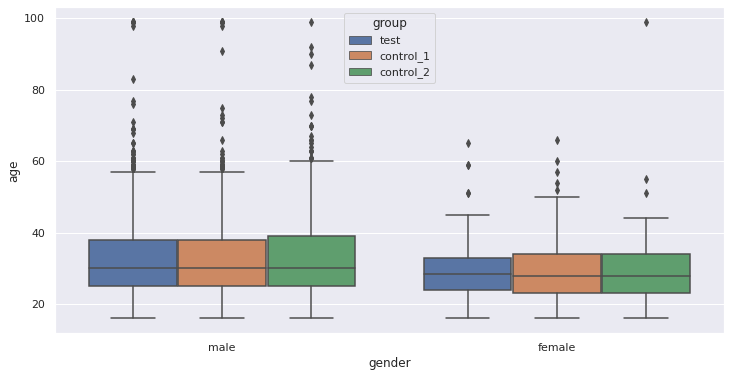

In [18]:
#смотрим на распределение возраста по группам и полу
sns.set(rc={'figure.figsize': (12, 6)})
sns.boxplot(data=all_users, x="gender", y="age", hue = 'group')
plt.show()

   Как мы выдим количество мужчин значительно превышает по своей численности количество женщин на сайте, и их средний  возраст  выше. 
   Также в данных наблюдаются выбросы, которые могут быть связаны, в частности, с неверным указанием возраста, при этом, в целом, в распределении пользователей по группам в зависимости от их пола и возраста сильных расхождений не наблюдается.

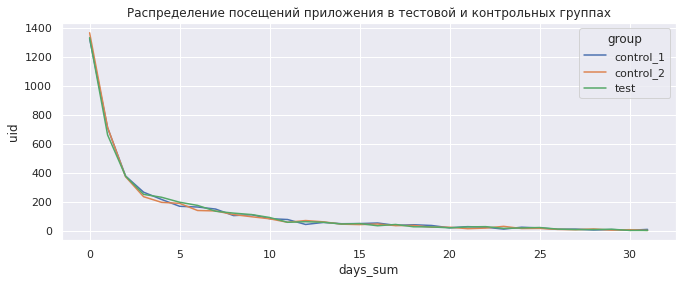

In [19]:
#посмотрим на распределение посещений пользователями приложения
days_view = all_users.groupby(['group','days_sum'], as_index = False).agg({'uid':'count'})
sns.set(rc={'figure.figsize': (11, 4)})
sns.lineplot(data=days_view, x="days_sum", y="uid", hue="group") \
   .set_title("Распределение посещений приложения в тестовой и контрольных группах")
plt.show()

Мы наблюдаем одинаковую тенденцию во всех группах относительно уменьшения количества дней посещения приложения с момента регистрации, при этом большинство пользователей используют приложение только в день регистрации и в течение первых 5 дней.

In [20]:
#количество пользователей, которые обладали премиум-подпиской
print(all_users.query('was_premium == "1.0"').groupby(['group','was_premium'], as_index = False).agg({'uid':'count'}).sort_values('uid'))

       group  was_premium  uid
2       test          1.0  408
1  control_2          1.0  411
0  control_1          1.0  436


In [21]:
#количество пользователей, которые сейчас обладают статусом премиум
print(all_users.query('is_premium == "1.0"').groupby(['group','is_premium'], as_index = False).agg({'uid':'count'}).sort_values('uid'))

       group  is_premium  uid
2       test         1.0  157
1  control_2         1.0  191
0  control_1         1.0  192


Как мы видим всего лишь 540 пользователей обладают премиум-подпиской, а 1255 ранее имели подписку, но перестали пользоваться этой услугой.
При этом в тестовой группе наблюдается снижение числа пользователей, которые имеют премиум-подписку.


In [22]:
#смотрим на разбивку пользователей по странам
all_users.groupby([ 'group','country'], as_index = False) \
          .agg({'uid':'count'}) \
          .pivot(index='country', columns='group', values='uid') \
          .head(5)


group,control_1,control_2,test
country,,,
Algeria,2.0,NaN,2.0
Argentina,389.0,397.0,396.0
Armenia,1.0,NaN,NaN
Australia,50.0,51.0,62.0
Austria,NaN,2.0,NaN


Из приведенной выше таблицы видно, что представители не всех стран вошли во все три группы, в связи с чем образовались пропуски в данных.

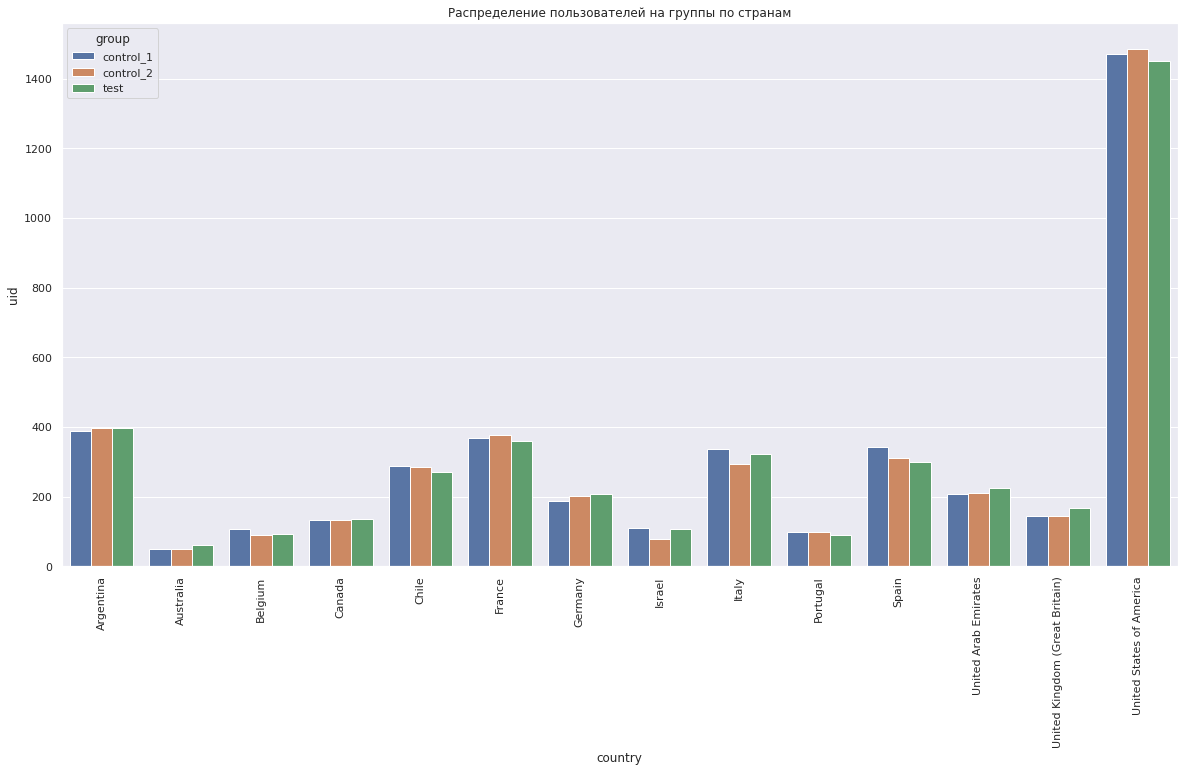

In [23]:
#построим график распределения пользователей групп по странам, установив планку ни менее 50 человек
users_by_country = all_users.groupby(['country', 'group'], as_index=False).agg({'uid': 'count'})
sns.set(rc={'figure.figsize': (20, 10)})
sns.barplot(data=users_by_country.query('uid >= 50'), x="country", y='uid', hue="group")\
    .set_title("Распределение пользователей на группы по странам")
plt.xticks(rotation=90)
plt.show()

При этом при рассмотрении распределения пользователей по странам по численности равным или более 50 человек мы наблюдаем относительно равнозначное распределение по группам. Значительная часть пользователей приложения приходится на США.

По условию задания следует, что изменение цены подписки произошло лишь в некоторых странах.  В связи с этим для дальнейшего исследования сделаем так, чтобы в датасете остались лишь страны, которые присутствуют в тестовой выборке, ведь в них и произошли изменения

In [24]:
#отбираем страны, имеющиеся во всех группах
country_test = all_users.query('group == "test"').groupby('country',as_index=False).agg({'uid':'count'})
country_control_1 = all_users.query('group == "control_1"').groupby('country',as_index=False).agg({'uid':'count'})
country_control_2 = all_users.query('group == "control_2"').groupby('country',as_index=False).agg({'uid':'count'})
countries = country_test.merge(country_control_2, on='country').merge(country_control_1, on='country')
countries = countries[['country']]

In [25]:
users_final = countries.merge(all_users, on='country')

In [26]:
#посмотрим насколько сократились группы
users_final.group.value_counts()
#наблюдается незначительное сокрашение численности групп 

control_1    4319
test         4271
control_2    4238
Name: group, dtype: int64

Также рассмотрим распределение нормированной выручки(total_revenue) в обработанной таблице.

In [27]:
users_final['total_revenue'].describe()

count     12828.000000
mean        527.555971
std        5539.912796
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      486330.000000
Name: total_revenue, dtype: float64

Распределение выручки очень перекошено, стандартное отклонение большое - что говорит о ненормальности распределения значения нормированной выручки, много нулевых значений.

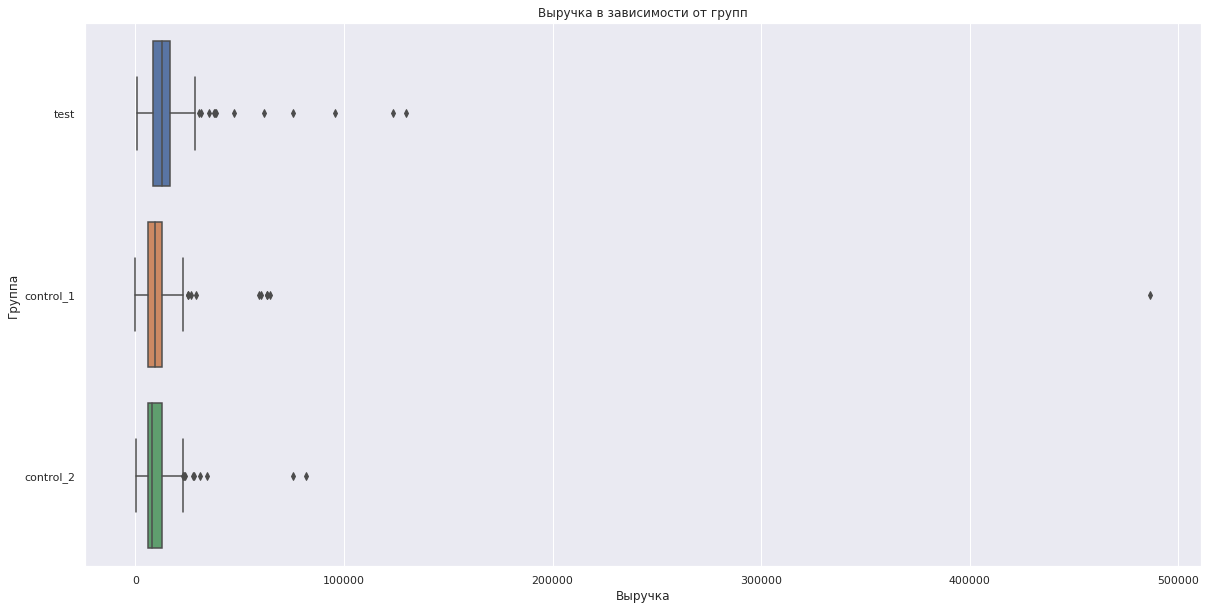

In [28]:
#распределение выручки в зависимости от групп
sns.boxplot(data=users_final[users_final.total_revenue != 0], x='total_revenue', y='group')
plt.title('Выручка в зависимости от групп')
plt.xlabel('Выручка')
plt.ylabel('Группа')
plt.show()

В группе контроль_1 наблюдается значительный выброс, который не позволяет нам получше посмотреть на данные, поэтому посмотрим на распределение без него

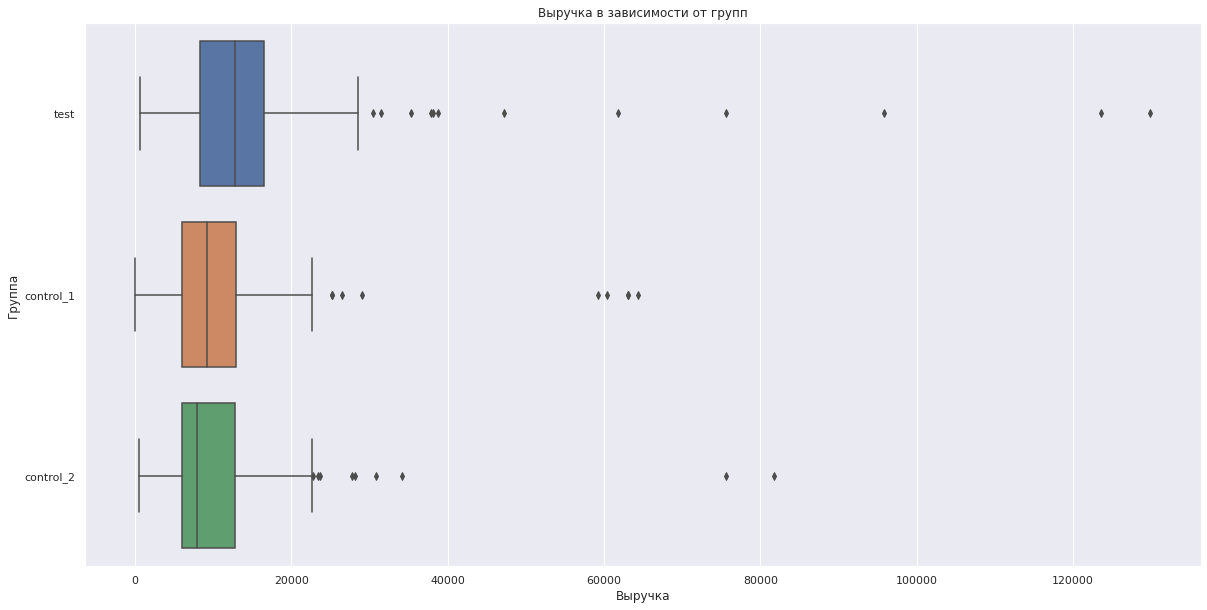

In [29]:
#распределение выручки в зависимости от групп
df = users_final.query('total_revenue < 200000')
sns.boxplot(data=df[df.total_revenue != 0], x='total_revenue', y='group')
plt.title('Выручка в зависимости от групп')
plt.xlabel('Выручка')
plt.ylabel('Группа')
plt.show()

На данном графике мы видим, что значения выручки заметно различается в группах. Так, в тестовой группе выручка имеет больший межквартильный размах, среднее значение заметно больше, чем у контрольных групп. Кроме того, имеются значительные выборосы во всех трех группах, насмотря на это, мы не будем их убирать, поскольку это может привести к потери данных о премиум клиентах.

 ### 1. Таблицы transactions

In [30]:
#посмотрим на общий размер таблиц transactions
print(f'Общее число строк и колонок в датасетах группы transactions:  тест:',transactions_test.shape, ', контроль 1:',
      trans_control_1.shape, ', контроль 2:', trans_control_2.shape)

Общее число строк и колонок в датасетах группы transactions:  тест: (273, 8) , контроль 1: (1007, 8) , контроль 2: (328, 8)


Таблица transactions_test

In [31]:
#применяем функцию
analysis_first(transactions_test)

Количество строк в файле: 273
Количество колонок в файле: 8
Количество дубликатов: 7


,column,Тип данных,Уникальные значения,Пропуски
0,uid,int64,146,0
1,country,object,17,0
2,joined_at,datetime64[ns],146,0
3,paid_at,datetime64[ns],258,0
4,revenue,int64,125,0
5,payment_id,int64,6,0
6,from_page,object,22,0
7,product_type,object,4,0


In [32]:
#удаляем дубликаты
transactions_test = transactions_test.drop_duplicates()

Таблица transactions_test_1

In [33]:
#применяем функцию
analysis_first(trans_control_1)

Количество строк в файле: 1007
Количество колонок в файле: 8
Количество дубликатов: 650


,column,Тип данных,Уникальные значения,Пропуски
0,uid,float64,193,630
1,country,object,18,630
2,joined_at,datetime64[ns],193,630
3,paid_at,datetime64[ns],335,630
4,revenue,float64,127,630
5,payment_id,float64,7,630
6,from_page,object,25,630
7,product_type,object,4,630


In [34]:
#удаляем дубликаты и удаляем остальные пропуски
trans_control_1 = trans_control_1.drop_duplicates()
trans_control_1.dropna(axis=0, inplace=True)

Таблица transactions_control_2

In [35]:
#применяем функцию
analysis_first(trans_control_2)

Количество строк в файле: 328
Количество колонок в файле: 8
Количество дубликатов: 5


,column,Тип данных,Уникальные значения,Пропуски
0,uid,int64,187,0
1,country,object,19,0
2,joined_at,datetime64[ns],187,0
3,paid_at,datetime64[ns],309,0
4,revenue,int64,123,0
5,payment_id,int64,6,0
6,from_page,object,18,0
7,product_type,object,4,0


In [36]:
#удаляем дубликаты
trans_control_2 = trans_control_2.drop_duplicates()

In [37]:
#Смотрим на распределение прибыли(revenue) в тестовой и контрольных группах
transactions_test[['revenue']]\
.describe()\
.rename(columns={'revenue': 'revenue_test'})\
.join(trans_control_1[['revenue']]\
            .describe()\
            .rename(columns={'revenue': 'revenue_control_1'}))\
.join(trans_control_2[['revenue']]\
            .describe()\
            .rename(columns={'revenue': 'revenue_control_2'}))\
[['revenue_test', 'revenue_control_1', 'revenue_control_2']]

,revenue_test,revenue_control_1,revenue_control_2
count,266.000000,356.000000,323.000000
mean,8767.766917,7007.876404,5907.111455
std,11216.235341,7985.995094,6615.180325
min,533.000000,26.000000,481.000000
25%,3129.750000,2804.750000,2340.000000
50%,6363.500000,6292.000000,4719.000000
75%,12597.000000,7312.500000,6350.500000
max,113477.000000,63037.000000,81796.000000


При первом анализе данных группы transactions мы видим, что колонки таблицы совпадают, вместе с тем имеются существенные различия в количестве строк, связанные, в том числе, с большим количеством дубликатов в таблице trans_control_1. 

Также в группах наблюдаются различия в распределении revenue.


### Объединение и дальнейшая обработка таблицы с платежами пользователей

Объединем датасеты из группы transactions в один датасет. При этом добавим колонку, в которой будет содержаться указание из какой группы были внесены данные (тест, контроль 1 и контроль 2).

In [38]:
transactions_test['group'] = 'test'
trans_control_1['group'] = 'control_1'
trans_control_2['group'] = 'control_2'
all_transactions = pd.concat([transactions_test, trans_control_1, trans_control_2], ignore_index=True)

In [39]:
#смотрим на объединенный датафрейм
all_transactions.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
0,891345942.0,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909.0,147.0,trial_vip_popup,trial_premium,test
1,892054251.0,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923.0,147.0,trial_vip_popup,trial_premium,test
2,892236423.0,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783.0,67.0,menu,other_type,test
3,892236423.0,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783.0,67.0,menu,other_type,test
4,892168170.0,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087.0,147.0,trial_vip_popup,trial_premium,test


In [40]:
#применяем функцию
analysis_first(all_transactions)

Количество строк в файле: 945
Количество колонок в файле: 9
Количество дубликатов: 0


,column,Тип данных,Уникальные значения,Пропуски
0,uid,float64,526,0
1,country,object,23,0
2,joined_at,datetime64[ns],525,0
3,paid_at,datetime64[ns],893,0
4,revenue,float64,265,0
5,payment_id,float64,7,0
6,from_page,object,28,0
7,product_type,object,4,0
8,group,object,3,0


Как мы видим количество уникальных пользователей меньше, чем количество строк в датафрейме, следовательно некоторые id пользователей могут встречаться не один раз при совершении разных операций.

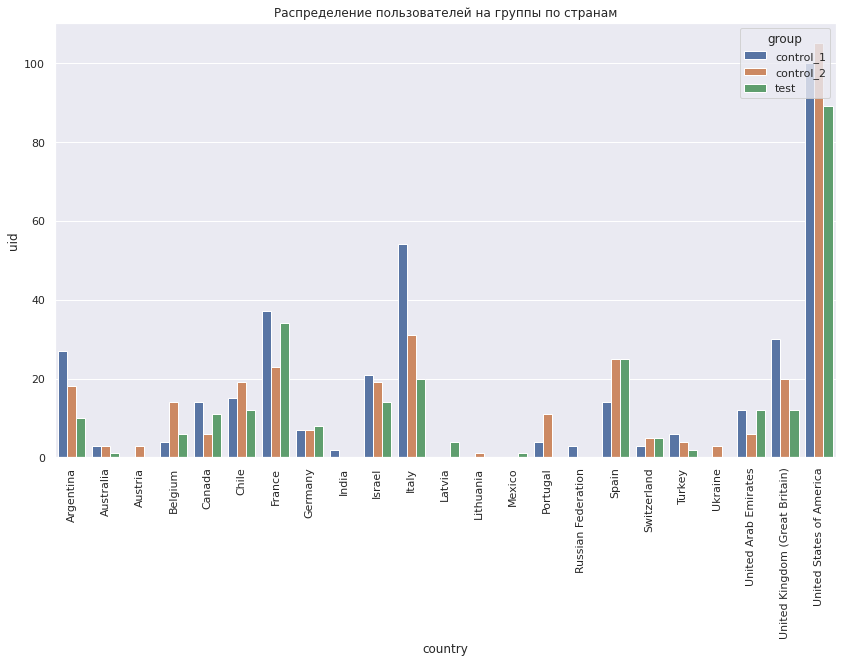

In [41]:
#смотрим на разбивку пользователей на группы по странам
trans_by_country = all_transactions.groupby(['country', 'group'], as_index=False).agg({'uid': 'count'})
sns.set(rc={'figure.figsize': (14, 8)})
ax = sns.barplot(data=trans_by_country.query('uid != 0'), x="country", y='uid', hue="group")
ax.set(title='Распределение пользователей на группы по странам')
plt.xticks(rotation=90)
plt.show()

Распределение пользователей наших групп по странам неравномерно, имеются страны, пользователи в которых не относятся ко всем трем исследуемым группам.

Также посмотрим на временной диапазон данных.

In [42]:
print(f'Дата и время первой регистрации:', all_transactions.joined_at.min())
print(f'Дата и время последней регистрации:', all_transactions.joined_at.max())

Дата и время первой регистрации: 2015-01-19 11:49:00
Дата и время последней регистрации: 2017-10-31 23:40:00


In [43]:
print(f'Дата и время первой покупки:', all_transactions.paid_at.min())
print(f'Дата и время последней покупки:', all_transactions.paid_at.max())

Дата и время первой покупки: 2016-12-14 16:16:00
Дата и время последней покупки: 2017-12-11 23:28:00


In [44]:
#посмотрим на данные по 2015 и 2016 году
all_transactions.query('joined_at == "2015-01-19 11:49:00"')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
330,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26.0,0.0,refund_VP,other_type,control_1
364,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637.0,0.0,refung_AP,other_type,control_1
481,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143.0,0.0,refund_WP,other_type,control_1


Убирем эти данные из общей талицы, поскольку указанные даты сильно отличаются от временного периода остальных операций. Есть предположение, что это была проверка приложения тестировшиком.

In [45]:
all_transactions = all_transactions.query('uid != "960936960.0"')

Далее создадим колонку с данными о том, сколько дней прошло с момента регистрации пользователя до покупки

In [46]:
all_transactions['days_to_pay'] = (all_transactions.paid_at - all_transactions.joined_at).dt.days

In [47]:
#посмотрим везде ли оплата произошла после регистрации
all_transactions.query('days_to_pay < 0').head(5)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group,days_to_pay
11,891861048.0,Canada,2017-10-26 02:55:00,2017-10-11 19:00:00,3588.0,68.0,none,premium_no_trial,test,-15
20,891806280.0,United States of America,2017-10-27 08:56:00,2017-03-11 10:57:00,8242.0,147.0,trial_vip_popup,trial_premium,test,-230
24,891786216.0,Spain,2017-10-27 18:20:00,2017-03-11 20:20:00,12818.0,147.0,trial_vip_popup,trial_premium,test,-230
25,892057347.0,France,2017-10-21 23:15:00,2017-08-11 01:56:00,1209.0,19.0,none,coins,test,-72
36,891589239.0,Italy,2017-10-31 14:16:00,2017-09-11 15:44:00,6305.0,19.0,empty_likes,coins,test,-50


! Нашли сбой в программе, необходимо обратить внимание разработчиков на эти данные. 

При этом, стоит заметить, что операции по оплате совершены 11 числа, скорее всего мог произойти сбой в правильном написании даты покупки, а именно: число месяца и дня указаны в ошибочном порядке. Что касается нашего исследования, поскольку оплата все-таки прошла, мы не будем избавляться от этих данных и продолжим наш анализ.

Узнаем количество пользователей, которые приобрели конкретные типы продукта:
* trial_premium – пробная премиум-подписка, 
* premium_no_trial – премиум-подписка без пробной, 
* coins – подписка за внутреннюю валюту, 
* other_type – другое

In [48]:
all_transactions.value_counts('product_type')

product_type
coins               358
premium_no_trial    289
trial_premium       182
other_type          113
dtype: int64

В условиях задания сказано, что в рамках эксперимента для новых пользователей из нескольких стран была изменена стоимость премиум-подписки, при этом стоимость пробного периода оставалась прежней. Следовательно, далее при расчете конверсии в подписку нас будут интересовать в первую очередь значения типа продукта premium_no_trial – премиум-подписка без пробной.

Посмотрим на распределение выручки по premium_no_trial.

In [49]:
prem_users_trans = all_transactions[all_transactions.product_type == 'premium_no_trial']

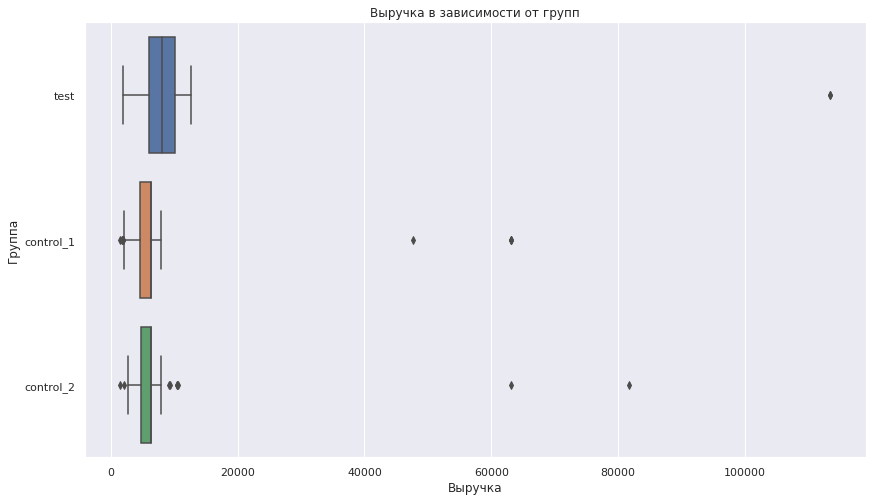

In [50]:
#распределение выручки в зависимости от групп
sns.boxplot(data=prem_users_trans, x='revenue', y='group')
plt.title('Выручка в зависимости от групп')
plt.xlabel('Выручка')
plt.ylabel('Группа')
plt.show()

Видим, что значения revenue заметно различаются в группах, имеются выборосы, в тестовой группе revenue имеет больший межквартильный размах, медианное значение заметно больше, чем у контрольных групп. Можно сделать предположение об увеличении дохода от продажи премиум-подписки без пробной версии.

### Объединение таблиц пользователей с транзакциями

Как мы помним у нас количество уникальных пользователей в таблице all_transactions превыщает число строк в датафрейме, поэтому для каждого пользователя определим сколько денег он потратил в приложении за время эксперимента, и уже данную таблицу присоединим к финальной таблице с пользователями

In [51]:
total_pay_trans = all_transactions.groupby('uid', as_index = False) \
                                  .agg({'revenue':'sum'})

In [52]:
#объединим датасеты
u_t = users_final.merge(total_pay_trans, how='left', on='uid').fillna(0)

In [53]:
#применяем функцию
analysis_first(u_t)

Количество строк в файле: 12828
Количество колонок в файле: 16
Количество дубликатов: 0


,column,Тип данных,Уникальные значения,Пропуски
0,country,object,25,0
1,uid,int64,12828,0
2,age,int64,68,0
3,attraction_coeff,int64,843,0
4,coins,float64,51,0
5,visit_days,object,2109,0
6,gender,object,2,0
7,age_filter_start,int64,67,0
8,age_filter_end,int64,81,0
9,views_count,int64,559,0


In [54]:
#посмотрим на суммы 
print(f'Сумма по total_revenue', u_t.total_revenue.sum())
print(f'Сумма по revenue', u_t.revenue.sum())

Сумма по total_revenue 6767488
Сумма по revenue 6700122.0


In [55]:
#пользователи с различиями в total_revenue и revenue
no = u_t.query('total_revenue != revenue')
no.head(3)

,country,uid,age,attraction_coeff,coins,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,days_sum,revenue
625,Argentina,891252072,43,326,0.0,"1,2,3,4,5,6,7,8,9",male,40,46,98,1.0,1.0,8814,control_1,9,7553.0
3066,France,892275462,31,310,0.0,"1,2,3,4,5,9,13,15,16",male,36,68,58,1.0,1.0,14885,test,9,58968.0
3476,France,892207959,21,230,0.0,"1,2,4,5,6,7,9,10,11,12,13,14,15,16,17,18,19,20...",male,18,24,430,1.0,1.0,18902,control_1,26,16380.0


In [56]:
no.uid.nunique()

22

Мы видим различие между 22 пользователями в распределение выручки total_revenue и revenue, при этом различия имееются в разных группах, скорее всего какие то транзакции неверно записались, в таком случае мы будем использовать в дальнейшем сумму - revenue(нормированная выручка), которая отражает доход от пользователей за период эксперимента.

#### Выводы по разделу
В целом мы подготовили данные для последующего проведения А/А и А/В тестов, а именно: удалены дубликаты; произведена фильтрация по странам (оставлены только те страны, которые есть в тестовой выборке, поскольку в них произошли изменения); заполнены пропуски; удалены записи, не относящиеся к периоду проведения эксперимента.

Также мы пришли к выводу о ненормальности расспределения показателей выручки (total_revenue, revenue), выявили выбросы в данных, вместе с тем, решили не избавляться от них, поскольку подобное может привести к потери информации о "вип-клиентах", которые тратят большие суммы в приложении. При этом были установлены различия в total_revenue и revenue в отношении 22 пользователей, которые могут быть связанны в том числе с проблемами технического характера, однако поскольку показатель revenue взят из таблиц по транзакциям и представляет собой сумму, потраченную клиентом за период эксперимента, мы будем использовать в дальнейшем его, для иных расчетов.

## Постановка целей 

Итак, в задании сказано, что мы имеем дело с дейтинговым приложением, которое используется пользователями с целью поиска подходящего партнера. При этом цель самих создателей подобных проектов заключается в получении дохода от использования данного приложения, а одним из вариантов увелечения дохода является стимулирование пользователей на совершении какой-либо покупки в приложении, в нашем случае эксперимент проводился в отношении покупки премиум-подписки без пробной.

Для анализа прогресса по решению вопроса об увелечении дохода с помощью такого эксперимента нам помогут следующие метрики:
* ARPU (средняя выручка одного пользователя) и ARPPU (средняя выручка одного платящего пользователя), поскольку увеличение данных показателей означает увелечение дохода в целом
* Конверсия (CR) в покупку продукта premium_no_trial, которая будет отражать изменение количества премиум-подписок в связи с изменением цены, при этом следует внимательно следить за тем, чтобы показатели конверсии не падали, так как это бы означало, что мы теряям часть наших потенциальных покупателей


Учитывая изложенное, начнем нашу проверку с проведения А/А тестов.

### Проведение А/А теста (ARPU, ARPPU) 

Задача A/A-тестов преимущественно заключается в том, чтобы понять, корректно ли работает система сплитования. 
В А/А/B-тестах мы хотим принимать нулевую гипотезу в паре A1/A2 и отвергать на А1+А2/B. Дополнительная контрольная ветка служит страховкой. Для проверки системы сплитования будем использовать t-тест.

Применяя Т-критерий Стьюдента нужно помнить о следующем:
* Дисперсии внутри наших групп должны быть примерно одинаковы (требование гомогенности дисперсий). Проверить можно с помощью критерия Левена.
* Особенно важный вопрос — это требование к нормальности данных обеих групп при применении t-теста. Однако учитывая большой размер нашей выборки это требование можно опустить.

Гипотезы теста Левина:
* Нулевая гипотеза (H0): дисперсия среди групп одинакова.
* Альтернативная гипотеза (H1) : дисперсия среди групп не одинакова.

Пороговое значение - 0,05

* ARPU

In [57]:
print(stats.levene(u_t.query('group == "control_1"').revenue, u_t.query('group == "control_2"').revenue))

LeveneResult(statistic=1.368347596442459, pvalue=0.24212858043183158)


pvalue > 0,05 - требование о гомогенности дисперсий подтверждается

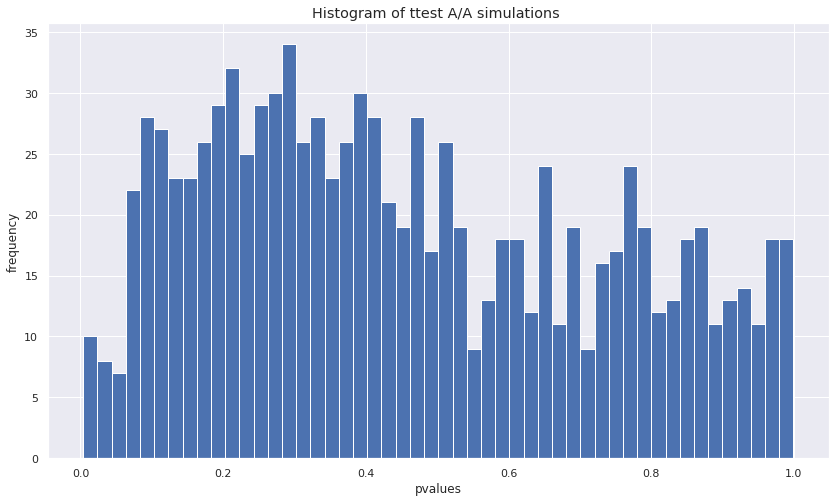

0.02

In [58]:
n = 100000
simulations = 1000
n_s = 1000
res = []

A0 = u_t.query('group == "control_1"').revenue
A1 = u_t.query('group == "control_2"').revenue

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = A0.sample(n_s, replace=False).values
    s2 = A1.sample(n_s, replace=False).values
    res.append(stats.ttest_ind(s1, s2)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

pvalue < 0.05, система сплитования работает корректно 

* ARPPU

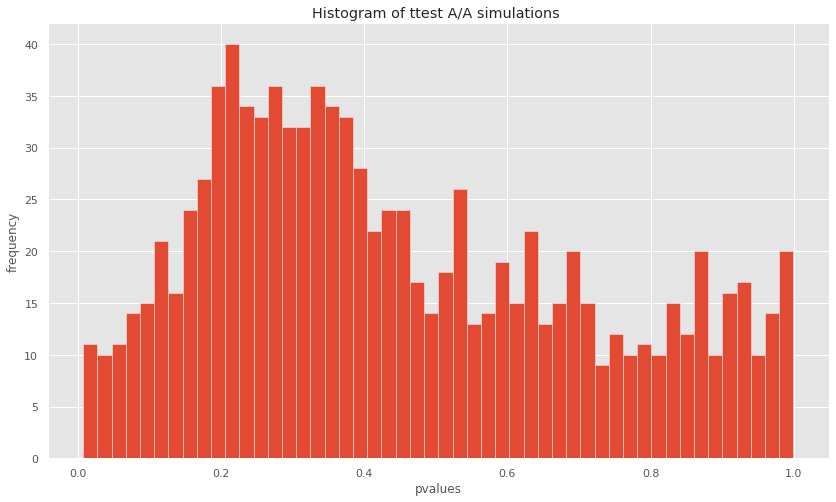

0.022

In [59]:
n = 100000
simulations = 1000
n_s = 50
res = []

A0 = u_t.query('group == "control_1" and revenue > 0').revenue
A1 = u_t.query('group == "control_2" and revenue > 0').revenue

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = A0.sample(n_s, replace=False).values
    s2 = A1.sample(n_s, replace=False).values
    res.append(stats.ttest_ind(s1, s2)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

pvalue < 0.05, система сплитования работает корректно

## А/B тест  (ARPU, ARPPU) 

После проверки системы сплитования на корректность переходим к А/Б тестам.Будем проверять по схеме A1/B и A2/B, поскольку у нас две контрольные группы.

Метрики эксперимента ARPU и ARPPU непрерывны, следовательно для их статистического анализа можно использовать методы сравнения средних (такие как t-test, bootstrap и т.д). Мы уже выяснили, что распределение величины revenue (суммированное по пользователям) отличается от нормального, а также имеет значительные выбросы. Использование t-test при таком распределении все же возможно, учитывая большой размер выборки, но, нам предпочтительнее использовать метод бутстрапа, который позволяет нам  строить доверительный интервал для любого параметра распределения, а для проверки гипотез — путём вычисления разницы такого интервала.


Выдвигаем гипотезу:

* H0 – статистически значимого различия между средними значениями в тестовой и контрольной группе нет (нулевая гипотеза)

* H1 – средние значения в тестовой и контрольной группе статистически значимо отличаются (альтернативная гипотеза)

Пороговый уровень значимости α=0.05.

In [58]:
#объявляем фукцию,которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = stats.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

* ARPU

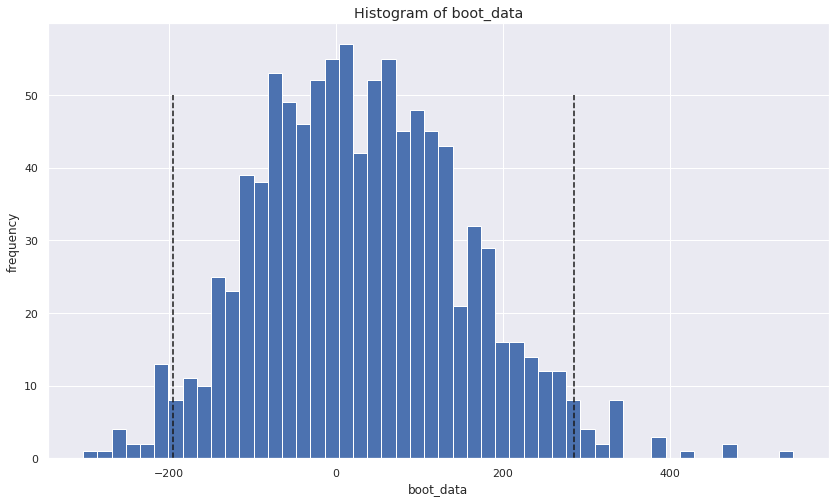

p-value 0.7914992337740117, ci                 0
0.025 -195.325602
0.975  285.261808


In [59]:
#контроль 1 и тест
booted_data = get_bootstrap(u_t[u_t.group == 'control_1'].revenue, u_t[u_t.group == 'test'].revenue)
print(f'p-value {booted_data["p_value"]}, ci {booted_data["ci"]}')

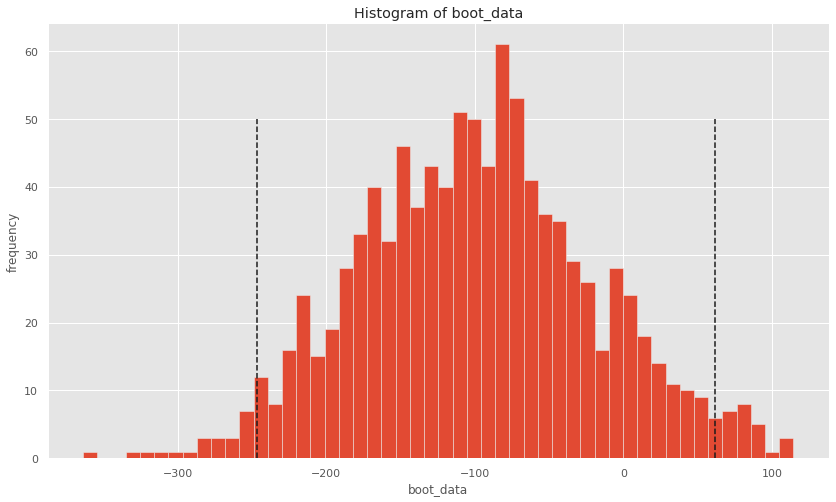

p-value 0.20991169717336744, ci                 0
0.025 -246.465207
0.975   61.454449


In [99]:
#контроль 2 и тест
booted_data = get_bootstrap(u_t[u_t.group == 'control_2'].revenue, u_t[u_t.group == 'test'].revenue)
print(f'p-value {booted_data["p_value"]}, ci {booted_data["ci"]}')

 p-value > 0,05, статистически значимых различий между средними значениями в контрольных и тестовой группах не обнаружено

* ARPPU

In [60]:
x1 = u_t.query('revenue > 0 and group == "control_1"')
x2 = u_t.query('revenue > 0 and group == "control_2"')
y  = u_t.query('revenue > 0 and group == "test"')

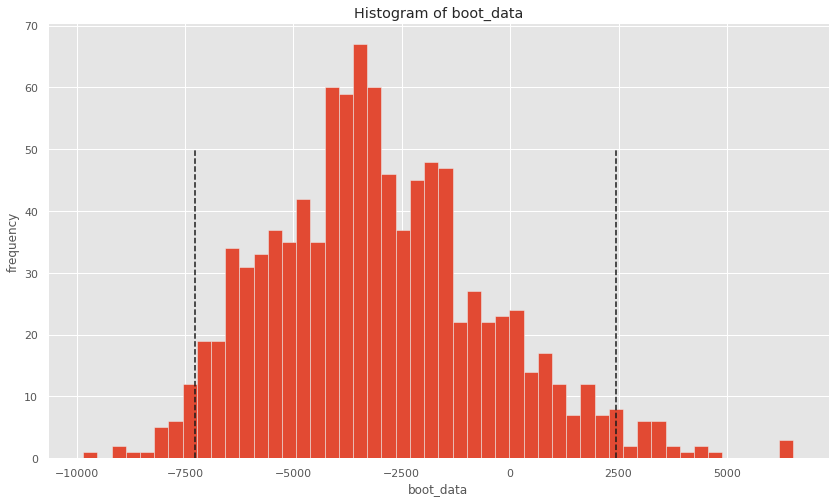

p-value 0.22809739613428937, ci                  0
0.025 -7277.303516
0.975  2444.121875


In [61]:
#контроль 1 и тест
booted_data = get_bootstrap(x1.revenue, y.revenue)
print(f'p-value {booted_data["p_value"]}, ci {booted_data["ci"]}')

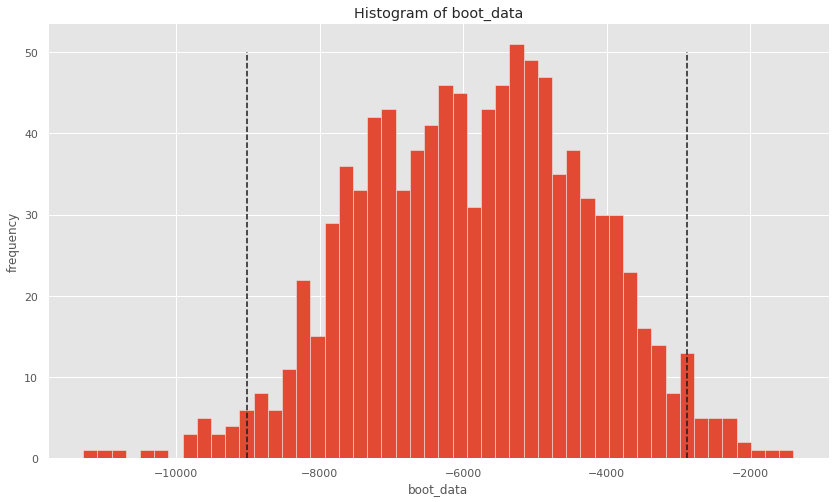

p-value 0.00023616398779426637, ci                  0
0.025 -9006.082027
0.975 -2889.420405


In [65]:
#контроль 2 и тест
booted_data = get_bootstrap(x2.revenue, y.revenue)
print(f'p-value {booted_data["p_value"]}, ci {booted_data["ci"]}')

обнаружено p-value < 0,05, при сравнении 2 контрольной группы с тестовой, что является основанием для отлокнения H0

Попробуем объеденить контроль 1 с контроль 2 и провести еще один тест(А1+А2/В)

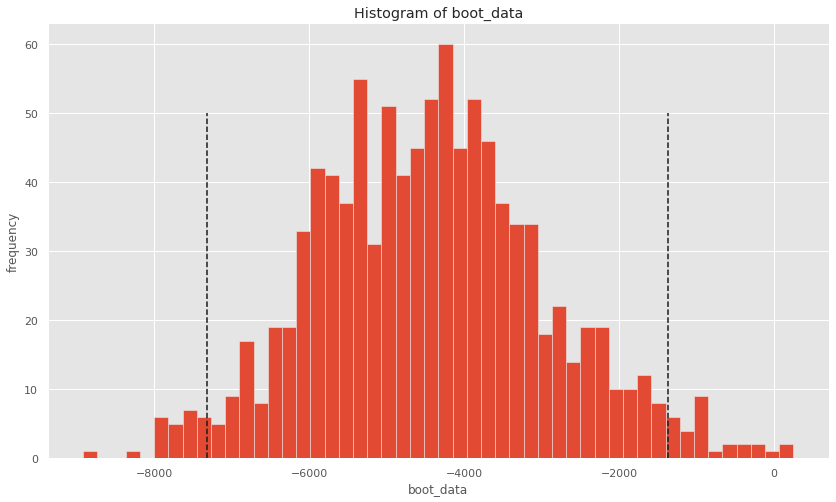

p-value 0.00023616398779426637, ci                  0
0.025 -9006.082027
0.975 -2889.420405


In [66]:
compare = get_bootstrap(u_t.query('group in ["control_1", "control_2"] and revenue > 0')['revenue'], # числовые значения первой выборки
                        u_t.query('group == "test" and revenue > 0')['revenue'])
print(f'p-value {booted_data["p_value"]}, ci {booted_data["ci"]}')

p-value < 0,05, также имеются основания для отклонения H0

### Проведение А/А и A/B теста (Конверсия (CR) в покупку продукта premium_no_trial) 

In [62]:
#отбираем пользователей, оплативших premium_no_trial впервые из общей таблицы по транзакциям
first_premium = all_transactions.query('product_type == "premium_no_trial"') \
                                .groupby('uid', as_index=False) \
                                .agg({'paid_at': 'min'}) 

In [64]:
#присвоим данным пользователем статус "1" 
first_premium['premium_buy'] = 1

In [65]:
#объединяем таблицу с премиум с нашей общей таблицей u_t, заполняя пропуски 0
premium = u_t.merge(first_premium, how='left', on='uid')
premium['premium_buy'] = premium.premium_buy.fillna(0)

In [66]:
#расчитываем конверсию
CR = premium.groupby('group', as_index=False) \
            .agg({'premium_buy' : 'mean'}) \
            .rename(columns = {'premium_buy' : 'CR'})
CR['CR'] = CR.CR.apply(lambda x: round(x * 100, 3))
CR

,group,CR
0,control_1,2.292
1,control_2,2.383
2,test,1.545


мы видим снижение конверсии в покупку premium_no_trial в тестовой группе, будем исследовать дальше.

* Проведение А/А теста

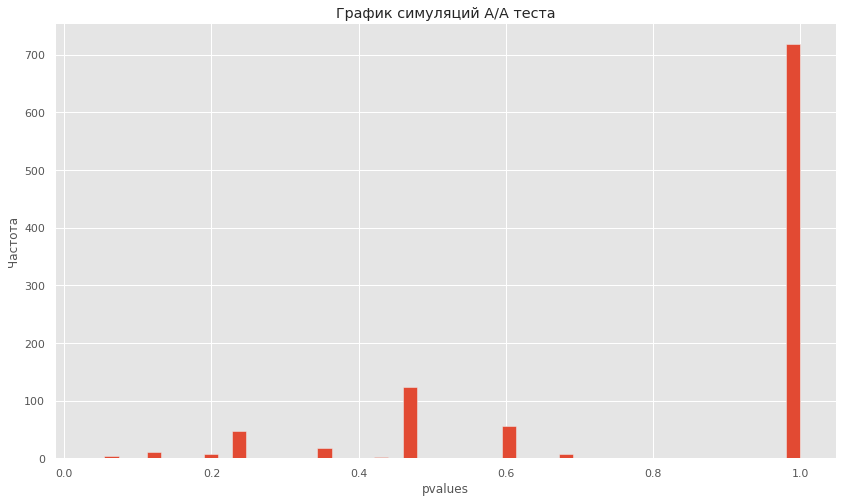

0.001

In [68]:
simulations = 1000 # количество симуляций
sample_size = 50  # размер подвыборки
results = []

# запускаем симуляции A/A теста
for i in tqdm(range(simulations)):
    sample1 = premium.query('group == "control_1"')[['group', 'premium_buy']].sample(sample_size, replace = False)
    sample2 = premium.query('group == "control_2"')[['group', 'premium_buy']].sample(sample_size, replace = False)
    results.append(chi2_contingency(pd.crosstab(pd.concat([sample1, sample2])['group'],
                                                pd.concat([sample1, sample2])['premium_buy']))[1]) # сохраняем pvalue в список

plt.hist(results, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('Частота')
plt.title("График симуляций A/A теста")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(results) <0.05) / simulations

pvalue < 0.05, система сплитования работает корректно

### A/B тест

Чтобы понять насколько статистически значимо различаются конверсии в покупку premium_no_trial - проведем A/B тест.
к равно
    Нулевая гипотеза (H0): Разницы между количеством пользователей, совершивших покупку в контрольной и тестовой группе, нет.
    Альтернативная гипотеза (H1): Разница между количеством пользователей, совершивших покупку в контрольной и тестовой группе, есть.

Поскольку данные в полях "premium_buy" и "group" являются категориальными переменными, то будем использовать тест Хи-квадрат

In [69]:
df = premium[['group', 'premium_buy']]
pd.crosstab(df.group, df.premium_buy)

premium_buy,0.0,1.0
group,,
control_1,4220,99
control_2,4137,101
test,4205,66


In [70]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df.group, df.premium_buy))
if p < 0.05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Отвергаем нулевую гипотезу


## Выводы:

Таким образом, мы приходим к выводу, что в целом эксперимент привел к неоднозначным результатам.

С одной стороны средняя выручка с платящих пользователей (ARPPU) статистически значимо возросла, при этом наблюдается снижение показателей средней выручки с пользователей платформы (ARPU) и конверсии в подписку premium_no_trial. Можно сделать вывод, что стоимость премиум-подписки без пробной была увеличена, что привело к снижению числа новых подписок в тестовой группе, вместе с тем, за счет такого поднятия цен удалось добиться увелечения показателя ARPPU.

Рекомендуется не раскатывать данное обновление платформы на всех пользователей приложения, а выбрать более узкий круг пользователей, на которых данные нововведения отражатся более эффективно.

### Для каких конкретных групп пользователей нововведение имеет смысл

Как мы помним из анализа таблиц users, 50 процентиль по анализу возраста составляет 30 лет, чтож попробуем проанализирвоать метрики ARPU и CR в разрезе двух групп: моложе 30 и старше 30.

* группа до 30 лет

In [115]:
#ARPU
x1 = u_t.query('group == "control_1" and age <= 30').revenue
x2 = u_t.query('group == "control_2" and age <= 30').revenue
y = u_t.query('group == "test" and age <= 30').revenue

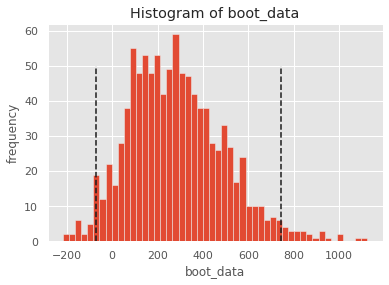

p-value 0.178156559203694, ci                 0
0.025  -69.537744
0.975  745.898358


In [118]:
#контроль 1 и тест
booted_data = get_bootstrap(x1, y)
print(f'p-value {booted_data["p_value"]}, ci {booted_data["ci"]}')

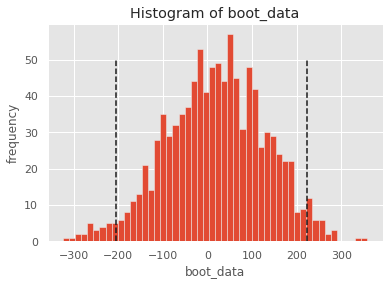

p-value 0.8600649803462799, ci                 0
0.025 -204.706167
0.975  223.437500


In [119]:
#контроль 2 и тест
booted_data = get_bootstrap(x2, y)
print(f'p-value {booted_data["p_value"]}, ci {booted_data["ci"]}')

In [71]:
premium.query('age <= 30').groupby('group', as_index=False).agg({'premium_buy': 'mean'})

,group,premium_buy
0,control_1,0.027778
1,control_2,0.029559
2,test,0.013310


 p-value > 0,05, статистически значимых различий между средними значениями в контрольных и тестовой группах не обнаружено; CR снизилась

* группа старше 30 лет

In [73]:
a1 = u_t.query('group == "control_1" and age > 30').revenue
a2 = u_t.query('group == "control_2" and age > 30').revenue
b = u_t.query('group == "test" and age > 30').revenue

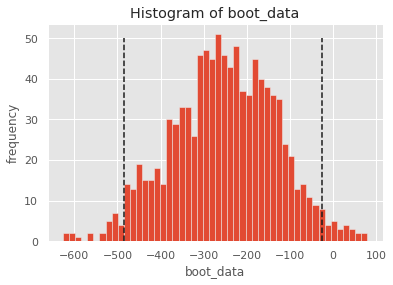

p-value 0.036240993763753566, ci                 0
0.025 -485.154300
0.975  -25.041663


In [125]:
#контроль 1 и тест
booted_data = get_bootstrap(a1, b)
print(f'p-value {booted_data["p_value"]}, ci {booted_data["ci"]}')

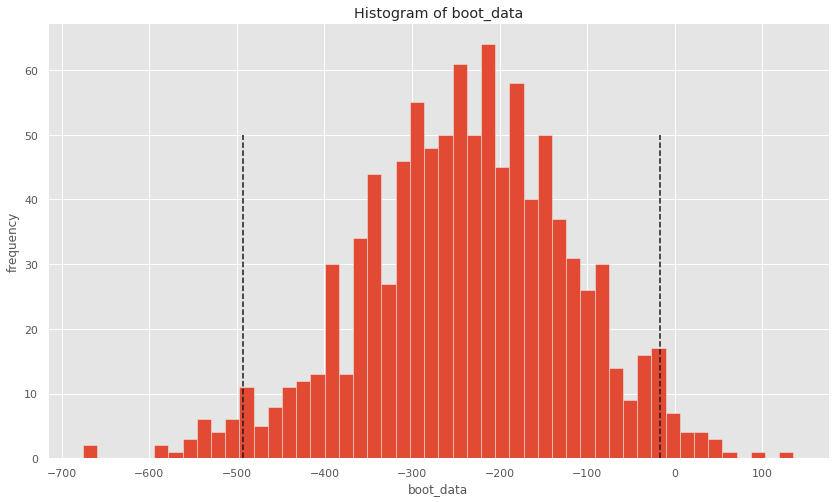

p-value 0.046577647747611875, ci                 0
0.025 -492.643416
0.975  -17.226275


In [81]:
#контроль 2 и тест
booted_data = get_bootstrap(a2, b)
print(f'p-value {booted_data["p_value"]}, ci {booted_data["ci"]}')

In [82]:
premium.query('age > 30').groupby('group', as_index=False).agg({'is_premium': 'mean'})

,group,is_premium
0,control_1,0.037853
1,control_2,0.041687
2,test,0.043629


Как мы видим в группе пользователей страше 30 лет в тестовой группе произошло увелечение конверсии в подписку, а также показатель ARPU. Считаем целессорбазным выкатывать изменения цены на премиум подписку только на данную группу пользователей.